# Classification



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the data
house_train = pd.read_csv('all/train.csv')
house_test = pd.read_csv('all/test.csv')


num_train = house_train.shape[0]
print('train size:',house_train.shape)
print('test size:',house_test.shape)


train size: (2051, 82)
test size: (879, 80)


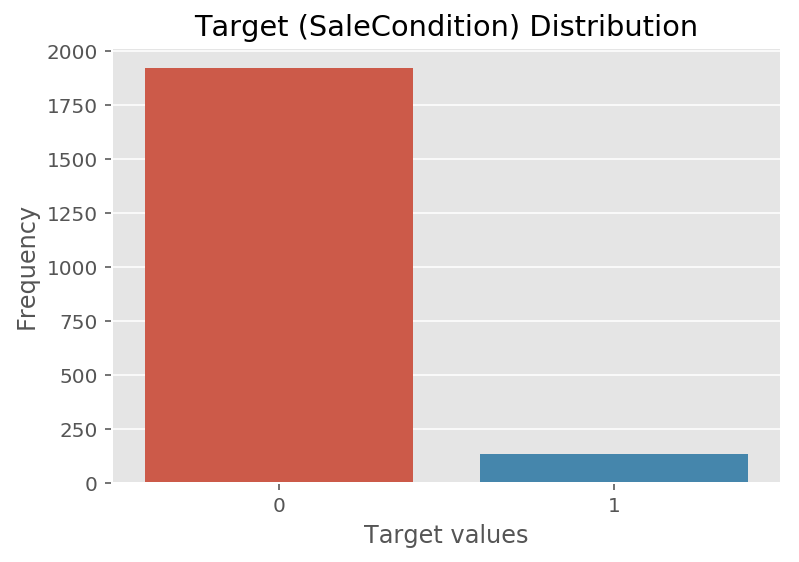

In [3]:
# remove spaces from column names
house_train.columns = [col.replace(' ','') for col in house_train.columns]
house_test.columns = [col.replace(' ','') for col in house_test.columns]

pd.Series(house_train['SaleCondition'].value_counts().values)

sns.countplot(x='SaleCondition' , data=house_train)
plt.xlabel('Target values')
plt.ylabel('Frequency')
plt.title('Target (SaleCondition) Distribution');


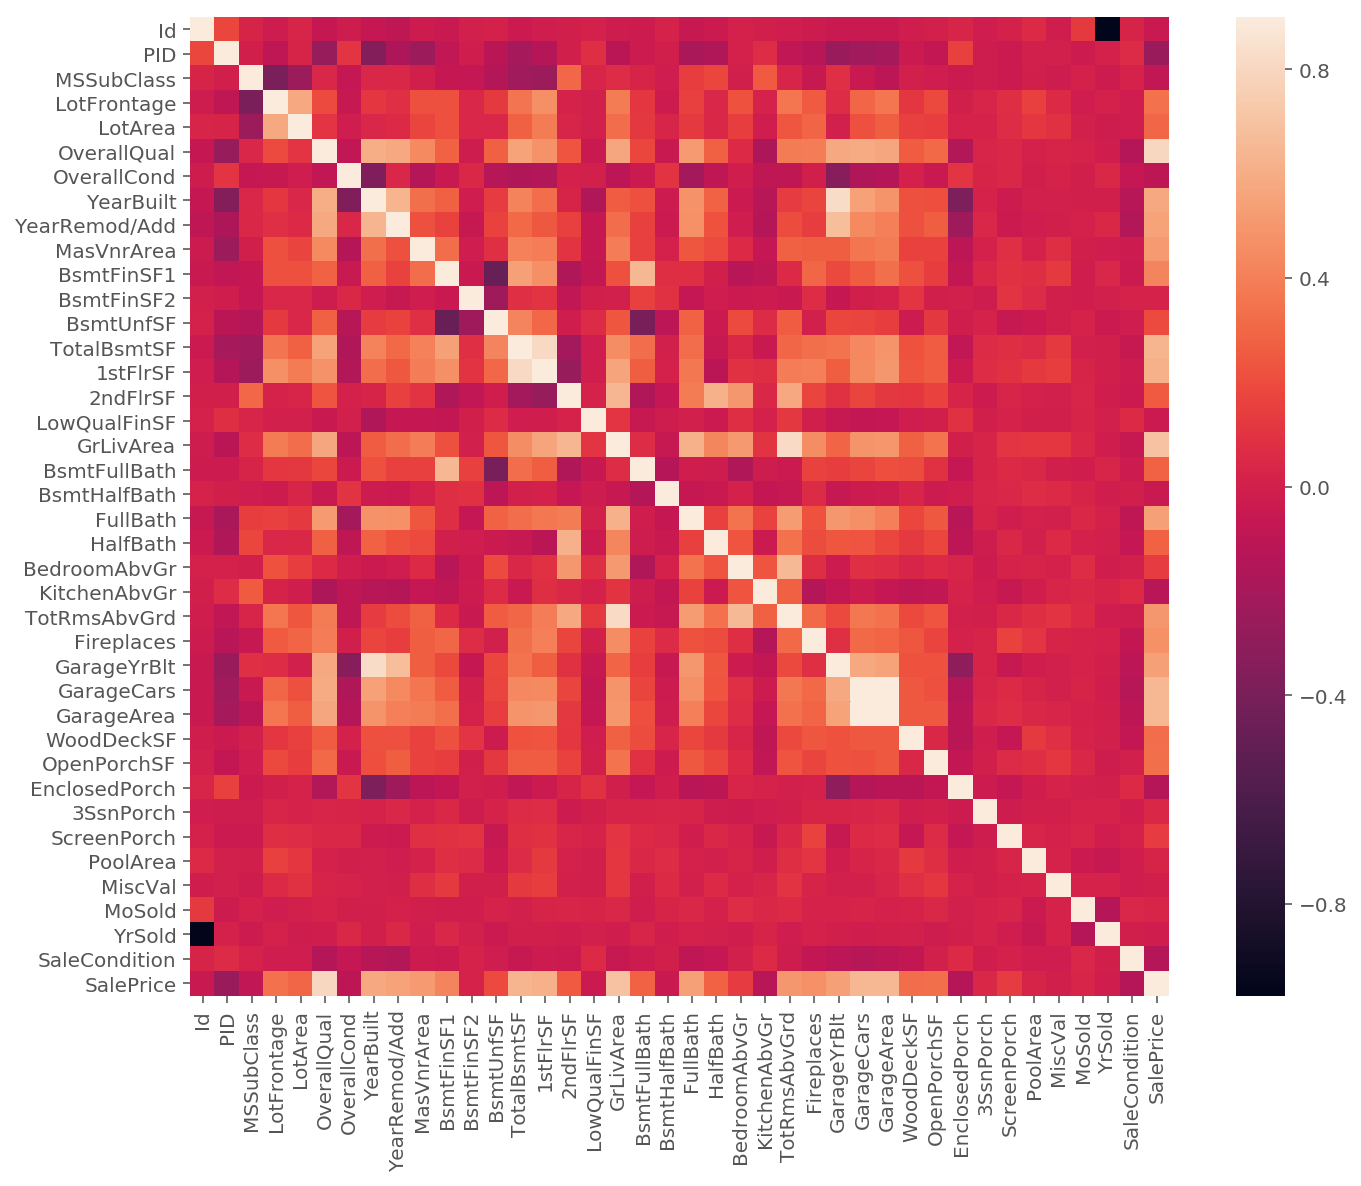

In [4]:
corrmat = house_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True);

In [5]:
# merging train data and test data for EDA
# we'll also remove 'Id' since this is not an informative feature
# removing the target columns: 'Sale Condition' and 'SalePrice'
house = pd.concat([house_train.drop(['Id', 'SalePrice','SaleCondition'],axis = 1), house_test.drop(['Id'],axis = 1)],ignore_index=True)

house.shape

(2930, 79)


## Features engineering

### Missing data

In [6]:
 # Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood [2]
house["LotFrontage"] = house.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# fill in with mode 
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    #As we cannot see test set we will take the mode for the training set
    train_mod = house_train[col].mode()[0]
    house[col].fillna(train_mod, inplace=True)

### Converting categorical columns & Handling remaining missing data 

We have two type of **non-numeric features** Ordinal and Nominal we will deal with each of them differently:



* OrdinalEncoder will be used to convert all **Ordinal** Data ( categorical variable that that can be ordered)

* OneHotEncoder will be used to convert **Nominal** Data ( without any particular implied order)


##### Handling missing data: 

we will fill the remaining missing data by "Na" (not available)

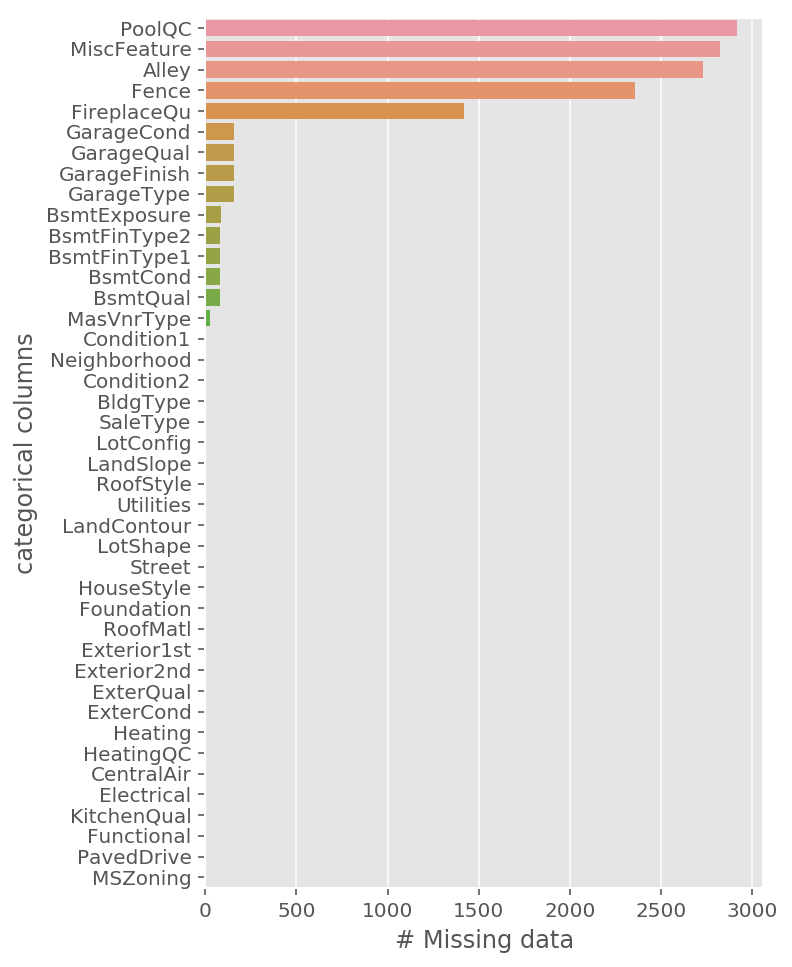

In [7]:
# missing values in categorical columns
miss_categ = (house.select_dtypes(exclude=[np.number]).isnull().sum()).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(y= miss_categ.index, x= miss_categ.values)
ax.set( xlabel="# Missing data" , ylabel="categorical columns");

In [8]:
# convert some numeric columns into strings [2]

NumStr = ["MSSubClass",'OverallCond',"MoSold","YrSold","YearBuilt","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    house[col]=house[col].astype(str)

In [9]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [10]:
# Converting Ordinal columns

ordinal_cols = ['KitchenQual', 'BsmtFinType2', 'GarageYrBlt', 'BsmtCond', 'GarageQual', 'YrSold',
                'BsmtExposure', 'LowQualFinSF', 'GarageCond', 'PoolQC', 'Fence', 'MSSubClass', 'HeatingQC', 
                'ExterCond', 'BsmtFinType1', 'BsmtQual', 'Alley', 'ExterQual', 'MoSold', 'FireplaceQu', 'YearBuilt',
                'LandContour', 'OverallCond', 'GarageFinish', 'LotShape', 'LandSlope','MSZoning','Neighborhood',
               'Functional','Condition1']

# fill the missing values with Na 
house[ordinal_cols] = house[ordinal_cols].fillna('Na')

ordinal_conv = OrdinalEncoder().fit_transform(house[ordinal_cols])

category_df1 = pd.DataFrame(ordinal_conv , columns=ordinal_cols )

In [11]:
# Converting Nominal columns
# we will not convert the Nominal columns because it will greatly increase the dimensionality of the features.
nominal_cols = ['Exterior2nd', 'Condition1', 'Neighborhood', 'RoofMatl', 'CentralAir', 'MSZoning', 'RoofStyle', 
                'MiscFeature', 'SaleType', 'GarageType', 'BldgType', 'HouseStyle', 'Street', 'MasVnrType', 'Exterior1st',
                'Condition2', 'Foundation', 'LotConfig', 'Utilities', 'Electrical', 'Functional', 'Heating', 'PavedDrive']

# fill the missing values with Na

house[nominal_cols] = house[nominal_cols].fillna('Na')
nominal_conv = OneHotEncoder().fit_transform(house[nominal_cols])

category_df2 = pd.DataFrame(nominal_conv.todense())

### Handling missing values in numerical columns

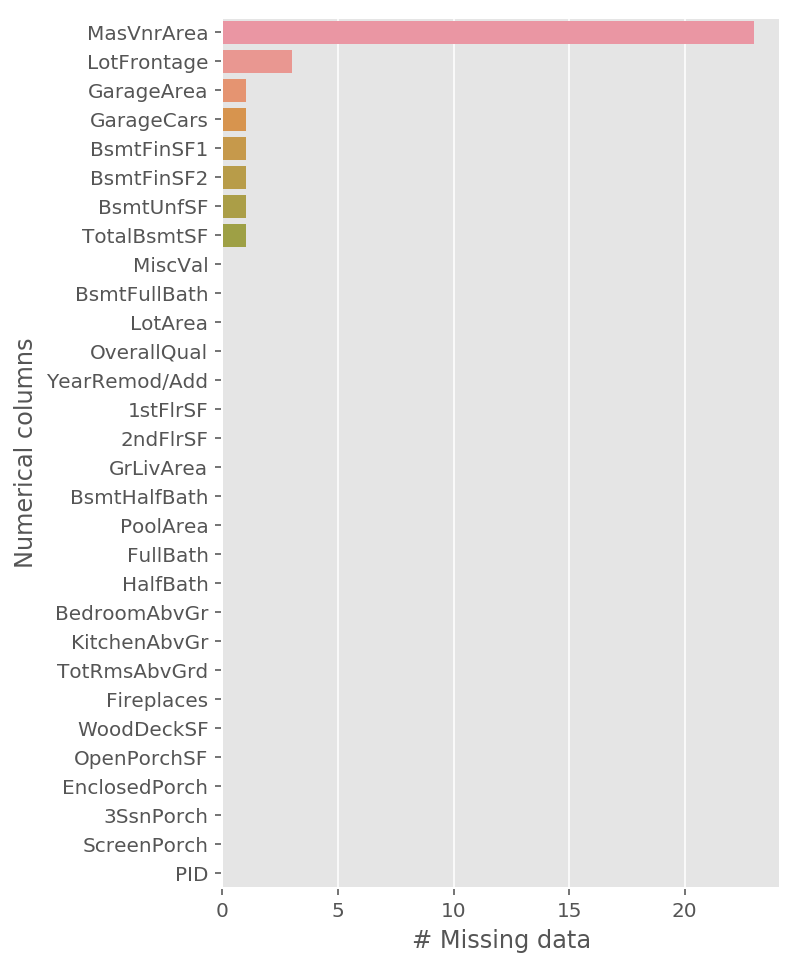

In [12]:
import copy
# missing values in numerical columns

numeric_df = copy.deepcopy( house.select_dtypes(include=[np.number]))
                                   
miss_numeric = numeric_df.isnull().sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(y= miss_numeric.index, x= miss_numeric.values)
ax.set( xlabel="# Missing data" , ylabel="Numerical columns");

In [13]:
numeric_df.fillna(0, inplace=True)

### Fixing the Skewness

After trying alot of experiments the models would did not achieve good results even with all the hyperparameter tuning, and after doing some research we realized that if the dataset skewed, then models wouldn’t perform well.

So, we need to fix the skewness to make a better prediction by the model.

In [14]:
from scipy.stats import skew

all_numeric = pd.concat([numeric_df, category_df1] , axis=1)

skewness = all_numeric.apply(lambda x: skew(x)).sort_values(ascending=False)
#sns.barplot(x=skewness.index , y = skewness.values)
skewness_features = skewness[abs(skewness) >= 1 ].index
all_numeric[skewness_features] = np.log1p(all_numeric[skewness_features])

### Train and Test sets

In [15]:
X = pd.concat([all_numeric, category_df2] , axis=1)
y = house_train.SaleCondition

In [16]:
X.shape , y.shape

((2930, 241), (2051,))

In [17]:
X_train = X[:num_train]
X_test = X[num_train:]

In [18]:
y.shape , X_train.shape

((2051,), (2051, 241))

### Feature selection

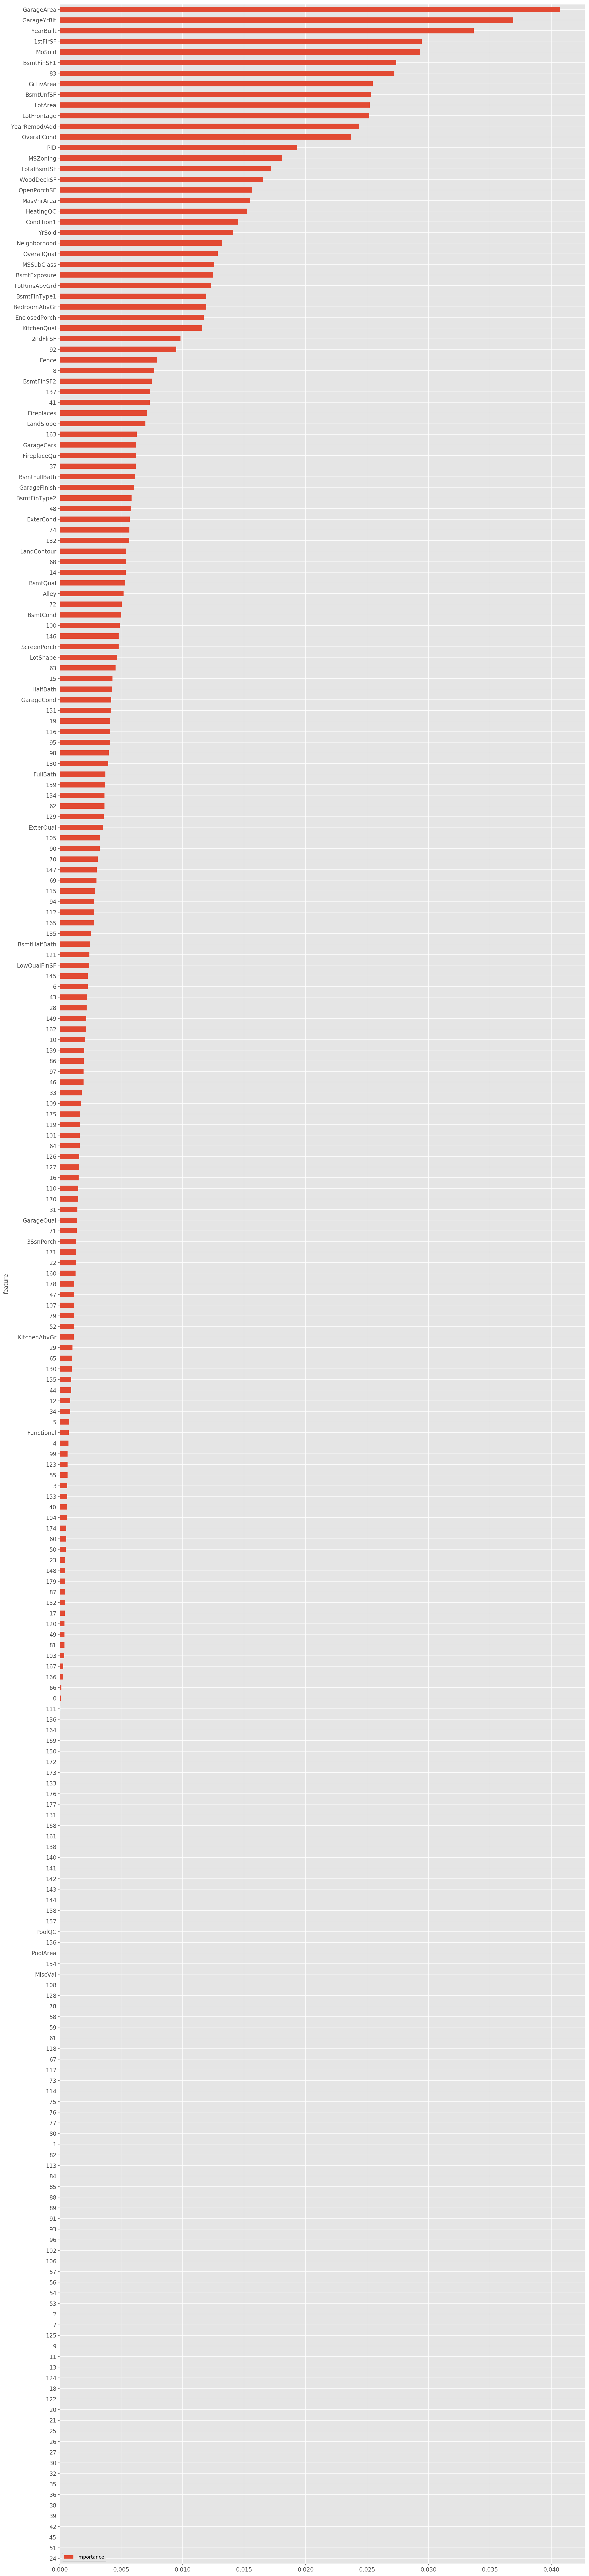

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
clf = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestClassifier())])


clf = clf.fit(X_train, y)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.named_steps['rf'].feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 100), fontsize=12);

### Adding more features based on the feature Importance


#### What we will do now is:
    1- adding the new features
    2- fix the skewed features
    3- get dummies

In [21]:
all_numeric = pd.concat([numeric_df, category_df1] , axis=1)

In [22]:
# adding the new features [2][3]

all_numeric['Total_sqr_footage'] = (all_numeric['BsmtFinSF1'] + all_numeric['BsmtFinSF2'] +
                                 all_numeric['1stFlrSF'] + all_numeric['2ndFlrSF'])

all_numeric['Total_Bathrooms'] = (all_numeric['FullBath'] + (0.5*all_numeric['HalfBath']) + 
                               all_numeric['BsmtFullBath'] + (0.5*all_numeric['BsmtHalfBath']))

all_numeric['Total_porch_sf'] = (all_numeric['OpenPorchSF'] + all_numeric['3SsnPorch'] +
                              all_numeric['EnclosedPorch'] + all_numeric['ScreenPorch'] + all_numeric['WoodDeckSF'])


all_numeric["TotalHouse"] = all_numeric["TotalBsmtSF"] + all_numeric["1stFlrSF"] + all_numeric["2ndFlrSF"]   
all_numeric["TotalArea"] = all_numeric["TotalBsmtSF"] + all_numeric["1stFlrSF"] + all_numeric["2ndFlrSF"] + all_numeric["GarageArea"]
            
all_numeric["TotalHouse_OverallQual"] = all_numeric["TotalHouse"] * all_numeric["OverallQual"]
all_numeric["GrLivArea_OverallQual"] = all_numeric["GrLivArea"] * all_numeric["OverallQual"]
all_numeric["oMSZoning_TotalHouse"] = all_numeric["MSZoning"] * all_numeric["TotalHouse"]
all_numeric["oMSZoning_OverallQual"] = all_numeric["MSZoning"] + all_numeric["OverallQual"]
all_numeric["oMSZoning_YearBuilt"] = all_numeric["MSZoning"] + all_numeric["YearBuilt"]
all_numeric["oNeighborhood_TotalHouse"] = all_numeric["Neighborhood"] * all_numeric["TotalHouse"]
all_numeric["oNeighborhood_OverallQual"] = all_numeric["Neighborhood"] + all_numeric["OverallQual"]
all_numeric["oNeighborhood_YearBuilt"] = all_numeric["Neighborhood"] + all_numeric["YearBuilt"]
all_numeric["BsmtFinSF1_OverallQual"] = all_numeric["BsmtFinSF1"] * all_numeric["OverallQual"]
            
all_numeric["oFunctional_TotalHouse"] = all_numeric["Functional"] * all_numeric["TotalHouse"]
all_numeric["oFunctional_OverallQual"] = all_numeric["Functional"] + all_numeric["OverallQual"]
all_numeric["LotArea_OverallQual"] = all_numeric["LotArea"] * all_numeric["OverallQual"]
all_numeric["TotalHouse_LotArea"] = all_numeric["TotalHouse"] + all_numeric["LotArea"]
all_numeric["oCondition1_TotalHouse"] = all_numeric["Condition1"] * all_numeric["TotalHouse"]
all_numeric["oCondition1_OverallQual"] = all_numeric["Condition1"] + all_numeric["OverallQual"]
            
           
all_numeric["Bsmt"] = all_numeric["BsmtFinSF1"] + all_numeric["BsmtFinSF2"] + all_numeric["BsmtUnfSF"]
all_numeric["Rooms"] = all_numeric["FullBath"]+all_numeric["TotRmsAbvGrd"]
all_numeric["PorchArea"] = all_numeric["OpenPorchSF"]+all_numeric["EnclosedPorch"]+all_numeric["3SsnPorch"]+all_numeric["ScreenPorch"]
all_numeric["TotalPlace"] = all_numeric["TotalBsmtSF"] + all_numeric["1stFlrSF"] + all_numeric["2ndFlrSF"] + all_numeric["GarageArea"] + all_numeric["OpenPorchSF"]+all_numeric["EnclosedPorch"]+all_numeric["3SsnPorch"]+all_numeric["ScreenPorch"]

In [23]:
all_numeric.shape

(2930, 84)

In [25]:
X = pd.concat([all_numeric, category_df2] , axis=1)
y = house_train.SaleCondition

X.shape , y.shape

((2930, 265), (2051,))

In [26]:
X_train = X[:num_train]
X_test = X[num_train:]

y.shape , X_train.shape

((2051,), (2051, 265))

In [27]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X[:num_train])
X_test_scaled = scaler.transform(X[num_train:])

X_train_scaled.shape , y.shape

((2051, 265), (2051,))

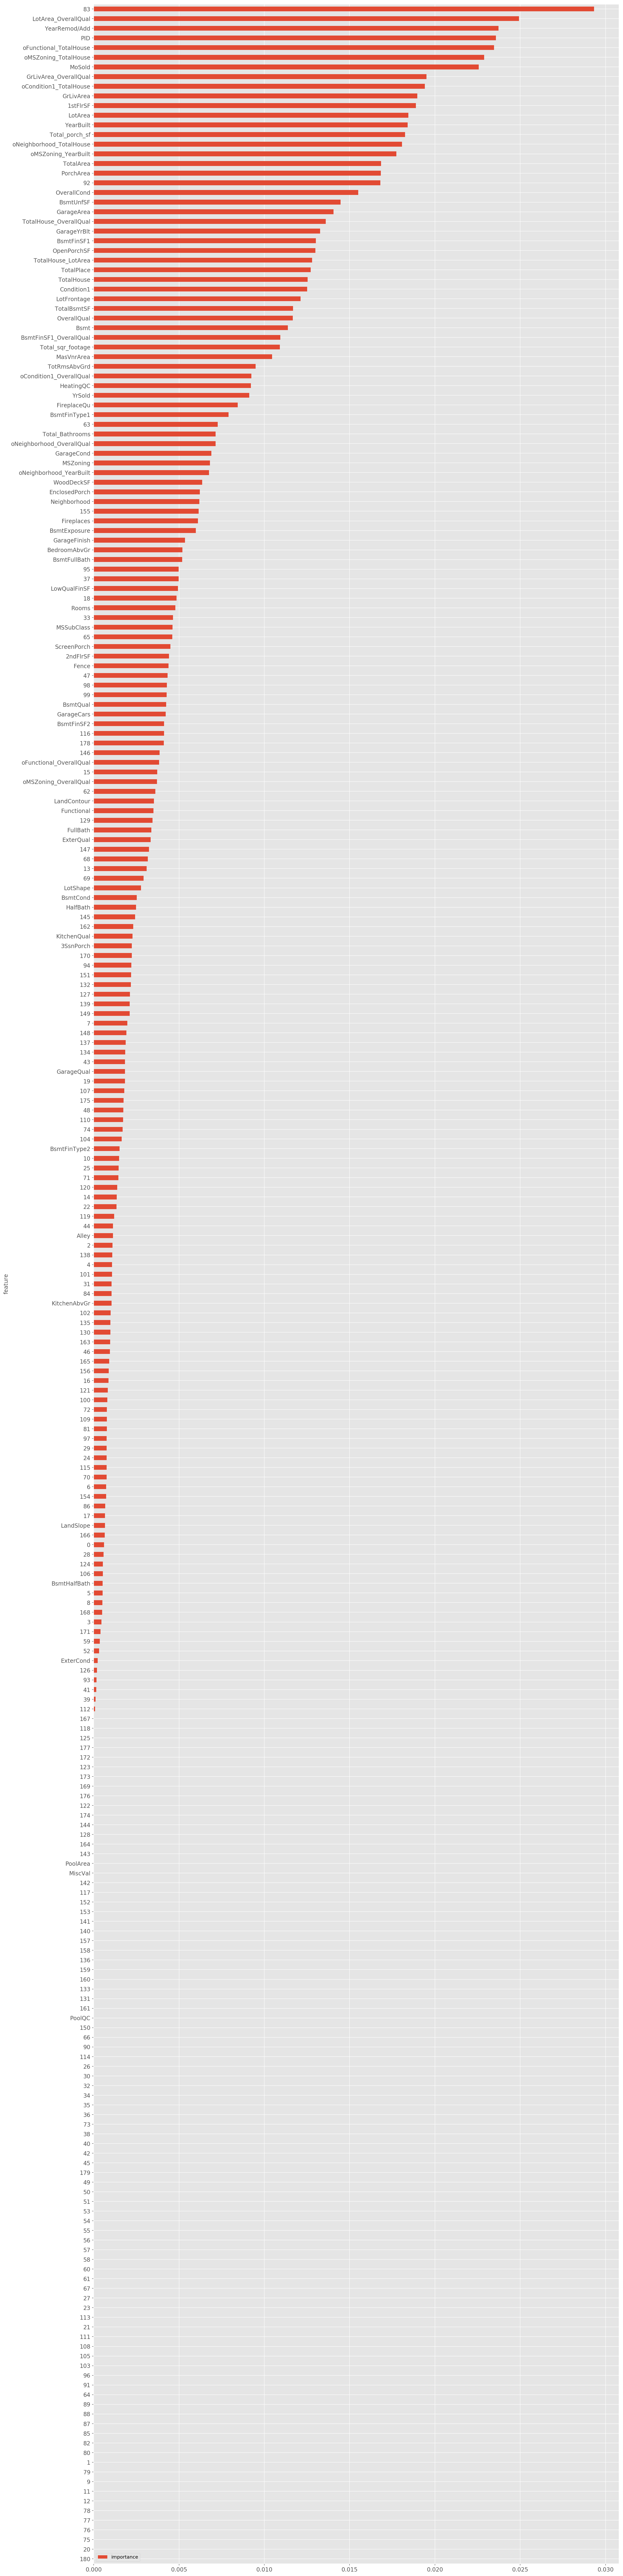

In [28]:
clf = clf.fit(X_train, y)

features = pd.DataFrame()
features['feature'] = X_train.columns### Using PCA


from sklearn.decomposition import PCA

pca = PCA(n_components=255)

X_train_pca =pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape
features['importance'] = clf.named_steps['rf'].feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 100), fontsize=12);

### Using PCA


In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA(n_components=255)

X_train_pca =pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((2051, 255), (879, 255))

### Modeling

In [38]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error ,f1_score
from math import sqrt



def get_models():

    #base learners
    knn = KNeighborsClassifier()
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    extra_tree = ExtraTreesClassifier()
    log_r = LogisticRegression()
    NN = MLPClassifier()
    
    boost = AdaBoostClassifier(n_estimators=50 )
    bagg = BaggingClassifier(n_estimators=500)
    gradi = GradientBoostingClassifier()
    
    xgb = XGBClassifier()
    
    lgb = LGBMClassifier()
    


    models = {
              'KNN': knn,
              'Decision Trees': dtc,
              'Random Forest': rfc,
              'Extra tree': extra_tree,
              'LR': log_r,
                'NN': NN,
              
              'AdaBoost': boost,
              'Bagging': bagg,
              'GradientBoost':gradi,
              'XGB':xgb,
              'LGB':lgb
        
              }

    return models



In [56]:
# Models comparison
models = get_models()

#acc function
def score_cv(model, X=X_train_pca, y=y ):
    k_fold = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_scores = cross_val_score(model, X , y , cv=k_fold, scoring='f1')
    return(cv_scores)

results = []
for name, model in zip(models.keys(),models.values()):

    f1_scores = score_cv(model)
    results.append(f1_scores)
    print( f"{name} f1 CV score: {np.mean(f1_scores)} , Std: {f1_scores.std()}.")



KNN f1 CV score: 0.06657952069716774 , Std: 0.07318881496658518.
Decision Trees f1 CV score: 0.20464625440324086 , Std: 0.03230671896318928.
Random Forest f1 CV score: 0.031481481481481485 , Std: 0.03866780188485389.


/Users/greener/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/greener/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Extra tree f1 CV score: 0.01666666666666667 , Std: 0.03333333333333334.
LR f1 CV score: 0.16798938775169675 , Std: 0.057723180440877216.


/Users/greener/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NN f1 CV score: 0.15125475706120867 , Std: 0.040857709443378805.
AdaBoost f1 CV score: 0.13915463099940523 , Std: 0.05286517476934653.
Bagging f1 CV score: 0.0639069264069264 , Std: 0.06857245683889483.
GradientBoost f1 CV score: 0.15556077467842172 , Std: 0.06315671396847697.


/Users/greener/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB f1 CV score: 0.031384615384615386 , Std: 0.03845045994292507.


/Users/greener/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


LGB f1 CV score: 0.0 , Std: 0.0.


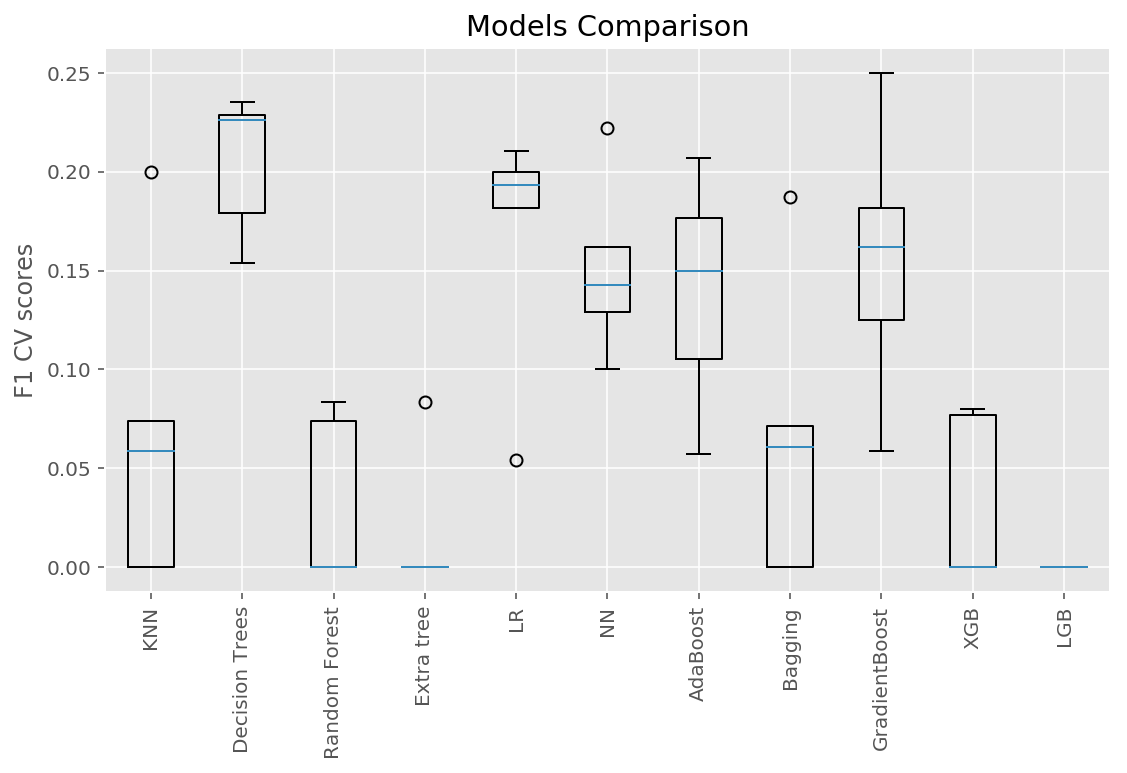

In [57]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='F1 CV scores');

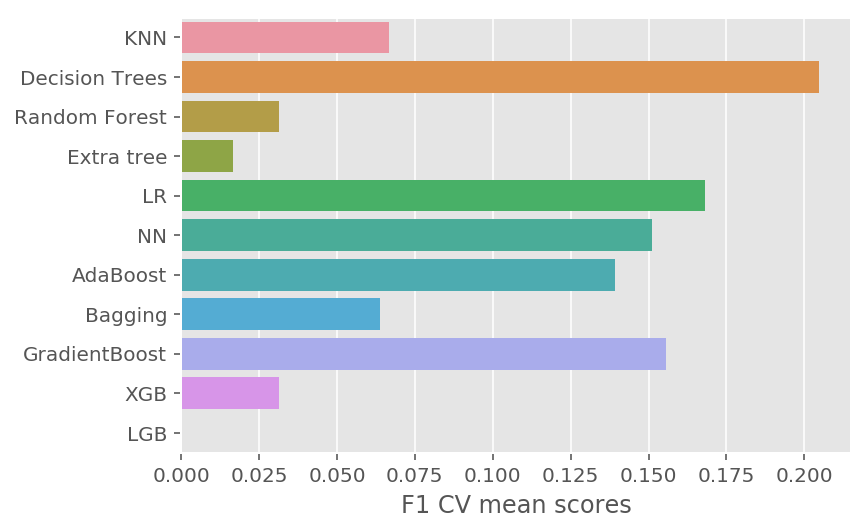

In [58]:
sns.barplot(y=[name for name in models.keys()],x=[np.mean(r) for r in results]);
plt.xlabel('F1 CV mean scores');

### Tunning

In [ ]:
# hyperparameters tuning for all models
dict_grid = {
    'rfr': { 'bootstrap': [True, False],
                    'max_depth': [10, 100],
                    'max_features': [5, 14],
                    'n_estimators': [100, 500],
                                    'n_jobs': [-1]},
             
              'etr': { 'n_estimators': [100, 500, 1000],
                      'max_depth': [10, 50, 100],
                    'max_features': range(50,401,50),
                    'min_samples_leaf': range(20,50,5),
                    'min_samples_split': range(15,36,5)
                     'n_jobs': [-1]},
             
              #'log_r': log_r,
              'lin_r': {'n_jobs':[-1]},
              'elastic': {'alpha': np.logspace(0, 5, 100),
                         'l1_ratio': [0.2 , 0.5 , 0.8]},
              
              'boost': {
                         'n_estimators': [50]},
    
              'bagg': { 'n_estimators': [ 500]},
              'gradi':{'learning_rate': [0.1],
                         'loss': ['ls'],
                         'max_depth': [3],
                         'max_features': ['log2'],
                         'n_estimators': [500],
                         'subsample': [0.8]},
                'xgb': {'n_estimators': [50] , ''}
              }


In [ ]:
# Models comparison
models = get_models()

tunned_models = []
for name, model , param in zip(models.keys(), models.values(), dict_grid.keys() ):
    
    tunned_model = GridSearchCV(model, param_grid = dict_grid[param] ,cv=5 , scoring='neg_mean_squared_error')
    tunned_model.fit(X_train_pca, y)
    print( name)
    print('best score: ',np.sqrt(-tunned_model.best_score_))
    print('best params: ',tunned_model.best_params_)
    print('_____________________________\n'*2)

### Final model
Selecting the best model based on CV score 

In [60]:
final_model = DecisionTreeClassifier()

score_cv(vote_model)

array([0.06666667, 0.07407407, 0.06666667, 0.        , 0.22222222])

In [61]:
score_cv(final_model).mean()

0.14174720445906888

In [62]:
vote_model = final_model.fit(X_train_pca , y)

In [63]:
y_pre = final_model.predict(X_test_pca)

In [64]:
y_pre

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [65]:
test_df = pd.DataFrame({'Id':house_test.Id,'SaleCondition':y_pre })

In [66]:
test_df.to_csv('Classification_f6.csv', encoding='utf-8' , index=False) 

###  Voting Classifier

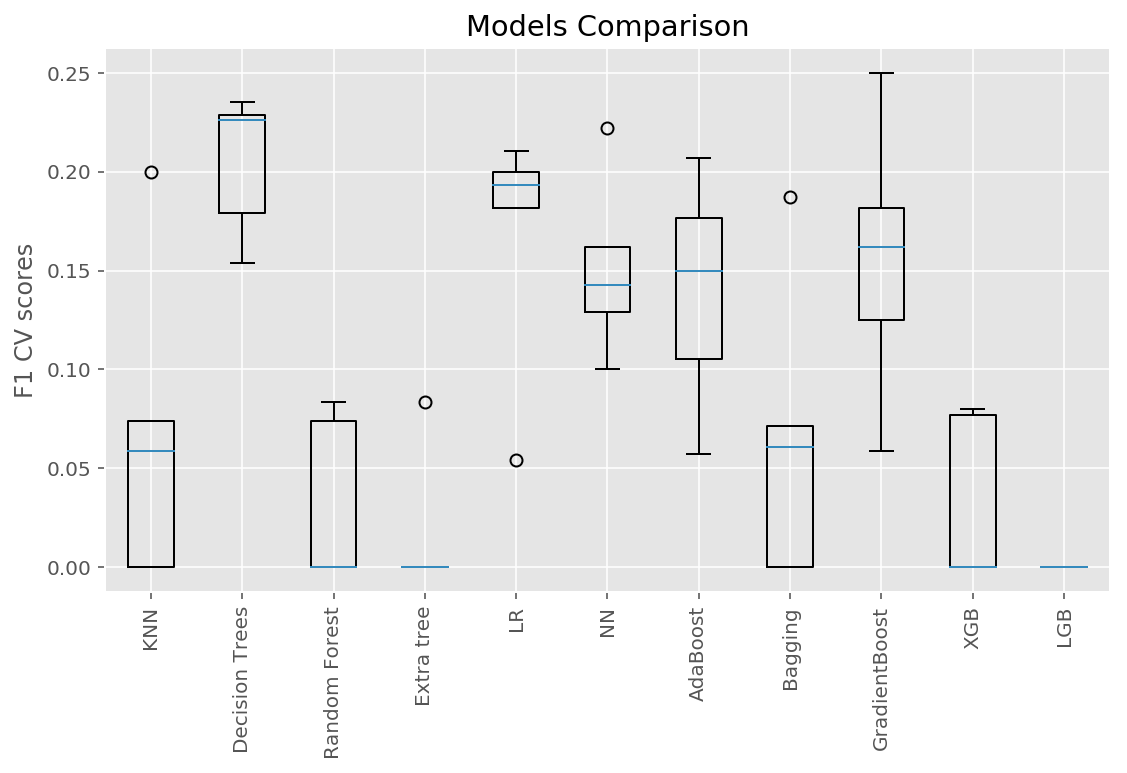

In [67]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='F1 CV scores');

In [68]:
# Selecting the best models based on GridSearchCV as estimators for VotingClassifier
base_learners = [('Decision Trees', DecisionTreeClassifier()),
                ('AdaBoost', AdaBoostClassifier()),
                 ('LR', LogisticRegression()),
                 ('GradientBoost', GradientBoostingClassifier())
                ]

In [69]:
vote_model = VotingClassifier( estimators= base_learners)

score_cv(vote_model)

array([0.        , 0.07692308, 0.13333333, 0.        , 0.08333333])

In [70]:
score_cv(vote_model).mean()

0.04584438549955792

In [71]:
vote_model = vote_model.fit(X_train_pca , y)

In [72]:
y_pre = vote_model.predict(X_test_pca)

In [73]:
y_pre

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [74]:
test_df = pd.DataFrame({'Id':house_test.Id,'SaleCondition':y_pre })

In [76]:
test_df.shape

(879, 2)

In [75]:
test_df.to_csv('Classification_f5.csv', encoding='utf-8' , index=False) 

# ##### References:

[1] How to deal with Skewed Dataset in Machine Learning? : https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc

[2] https://www.kaggle.com/kripakaran/house-prices

[3] https://www.kaggle.com/tomide/stacked-regressions-top-4-on-leaderboard